# Training Regression on 5point CrowdFlower data

In [83]:
import numpy as np
import pandas as pd
import csv
import math, itertools
import os
import subprocess

import matplotlib.pyplot as plt

from multiprocessing import Pool, Manager

from collections import Counter
from stop_words import get_stop_words
import natsort
from natsort import natsorted

from scipy import spatial
from scipy.stats import pearsonr, spearmanr

from sklearn.svm import SVR, LinearSVR
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import r2_score, f1_score 
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer

from imblearn.over_sampling import RandomOverSampler

from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras.models import Sequential,load_model, model_from_json
from keras.layers import Dense, Activation, Embedding, Bidirectional, Dropout, LSTM
from keras.regularizers import l2
import keras.backend as K

from theano import function

import warnings


In [2]:
moduleName = "fivePointRegression"
repositoryPath = '/home/vlaand/IpythonNotebooks/05_emotion_fivepoint_nuig'

directory = '/home/vlaand/IpythonNotebooks/05_emotion_fivepoint_nuig'

emoNames = ['confident','excited','happy', 'surprised']
# emoNames = ['sadness', 'disgust', 'surprise', 'anger', 'fear', 'joy']


In [3]:
from nltk.tokenize import TweetTokenizer
import nltk.tokenize.casual as casual
from drevicko.twitter_regexes import cleanString, setupRegexes, tweetPreprocessor
import preprocess_twitter

def preprocess_tweet(text):    
    text = casual.reduce_lengthening(text)
    text = cleanString(setupRegexes('twitterProAna'),text)   
    text = ' '.join([span for notentity,span in tweetPreprocessor(text, ("urls", "users", "lists")) if notentity])
    text = text.replace('\t','')
    text = text.replace('< ','<').replace(' >','>')
    text = text.replace('):', '<sadface>').replace('(:', '<smile>')
    text = text.replace(" 't", "t")#.replace('#','')
    return text

def tokenise_tweet(text):
    text = preprocess_twitter.tokenize(text)
    text = preprocess_tweet(text)     
    return ' '.join(text.split())

tokenise_tweet.regexes = setupRegexes('twitterProAna')

imported regex as re


In [6]:
from collections import defaultdict
import numpy as np
import pandas as pd
import csv

def _load_tweets(filename = "tweet.txt"):

    tweets_text = []

    for line in open(filename, 'rb'):

        line = line.decode("utf-8")
#         tw_text = ' '.join(tokenise_tweet(line))
        tw_text = tokenise_tweet(line.split())
        tweets_text.append(tw_text)
    
    return(tweets_text)

def _load_labels(filename = "labels.txt"):
    
    labels = []
    for line in open(filename, 'rb'):
        labels.append(line.decode('utf-8').replace('\n','').split(','))
    header, labels = labels[0], labels[1:]
    return(labels)

def _read_csv(filename = "data.csv", header=True):
    
    df = pd.read_csv(filepath_or_buffer=filename)    
    
    tweets_list = []
    labels_list = []
    conf_list = []
    
    for row in df.iterrows():
        tweets_list.append(tokenise_tweet(row[1]['tweet']))
        labels_list.append([row[1][emo]for emo in emoNames])         
        #conf_list.append([row[1][emo+'_conf']for emo in emoNames])
    return tweets_list,labels_list


# tweets = _load_tweets(filename = "/home/vlaand/IpythonNotebooks/cf-5point-data/tweet")
# labels = _load_labels(filename = "/home/vlaand/IpythonNotebooks/cf-5point-data/labels-lowConfidence.csv")

tweets,labels = _read_csv(filename = "/home/vlaand/IpythonNotebooks/cf-5point-data/data-full5.csv",header=True)
# print(len(tweets), 'tweets,',len(labels),'labels')

## WORD FREQUENCIES

1854 5157
Populating the interactive namespace from numpy and matplotlib


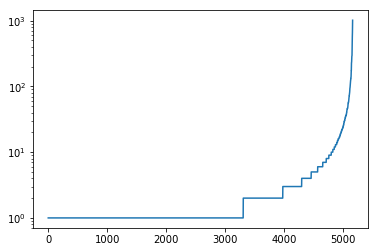

In [7]:
from collections import Counter
from stop_words import get_stop_words
WORD_FREQUENCY_TRESHOLD = 2

import os
from sklearn.externals import joblib


def ifExists(filename):
    dir = os.path.dirname(filename)
    try:
        os.stat(dir)
    except:
        os.mkdir(dir) 
        
def checkFolder(filename):
    dir = os.path.dirname(filename)
    try:
        os.stat(dir)
    except:
        os.mkdir(dir) 

def _get_unique_tokens(tweets):    
    return(Counter(token for tweet in tweets for token in tweet.split()))

def _save_unique_tokens(tokens, filename='wordFrequencies.dump'):
    
    checkFolder(filename)
    _ = joblib.dump(tokens, filename=filename, compress=9)
    

def _plot_word_frequencies(wordFrequencies, WORD_FREQUENCY_TRESHOLD = 3):
    
    freqs = []
    for t,c in wordFrequencies.items():
        freqs.append(c)
        
    q = 0
    for t,c in wordFrequencies.items():
        if(c >= WORD_FREQUENCY_TRESHOLD):
            q+=1
    print(q, len(wordFrequencies))
    %pylab inline
    semilogy(arange(len(freqs)),sorted(freqs))
    show()
    

def _reduce_text(text, LANGUAGE='en', WORD_FREQUENCY_TRESHOLD = 3):    

    stop_words = get_stop_words(LANGUAGE)

    tweets_reduced = []

    for tw in tweets:
        tweet_r = []
        for token in tw.split():
            if(wordFrequencies[token] >= WORD_FREQUENCY_TRESHOLD):
                if(not token in stop_words):
                    tweet_r.append(token)

        tweets_reduced.append( ' '.join(tweet_r)  )
        
    return(tweets_reduced)

wordFrequencies = _get_unique_tokens(tweets)
_save_unique_tokens(tokens=wordFrequencies,filename = '/home/vlaand/IpythonNotebooks/cf-5point-data/wordFrequencies.dump')
_plot_word_frequencies(wordFrequencies, WORD_FREQUENCY_TRESHOLD = WORD_FREQUENCY_TRESHOLD)
tweets_reduced = _reduce_text(tweets, WORD_FREQUENCY_TRESHOLD = WORD_FREQUENCY_TRESHOLD)

1744 1744
Populating the interactive namespace from numpy and matplotlib


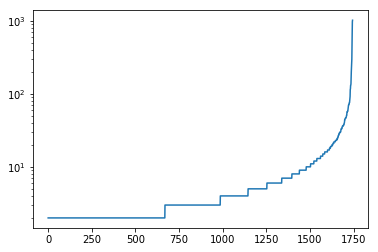

In [8]:
wordFrequencies2 = _get_unique_tokens(tweets_reduced)
_plot_word_frequencies(wordFrequencies2, WORD_FREQUENCY_TRESHOLD = WORD_FREQUENCY_TRESHOLD)

## N-GRAMS

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
NGRAM_VALUE = 4

print('NGRAM_VALUE =',NGRAM_VALUE)

NGRAM_VALUE = 4


#### Save ngramizer

In [10]:
def _save_ngramizer(filename = 'ngramizer.dump'):
    checkFolder(filename)
    _ = joblib.dump(ngramizer, filename=filename, compress=9)
    print(filename+' saved')
    
vectorizer = CountVectorizer(ngram_range = (1,NGRAM_VALUE),token_pattern=r'\b\w+\b', min_df=WORD_FREQUENCY_TRESHOLD)
ngramizer = vectorizer.fit(tweets_reduced)
vec = ngramizer.transform(tweets_reduced).toarray()
print(len(vec), len(vec[0]))
    
_save_ngramizer(filename = '/home/vlaand/IpythonNotebooks/cf-5point-data/5gramizer.dump')

2019 2429
/home/vlaand/IpythonNotebooks/cf-5point-data/5gramizer.dump saved


#### Load ngramizer

In [12]:
def _load_ngramizer(filename = 'ngramizer.dump'):
    checkFolder(filename)
    ngramizer = joblib.load(filename = filename)
    print(filename+' loaded')
    return ngramizer

# ngramizer = _load_ngramizer('/home/vlaand/IpythonNotebooks/senpy-plugins-NUIG/hashTagClassification/ngramizers/'+str(NGRAM_VALUE)+'gramizer.dump')
# ngramizer = _load_ngramizer('/home/vlaand/IpythonNotebooks/senpy-plugins-NUIG/hashTagClassification/ngramizers/ngramizer.dump')

vec = ngramizer.transform(tweets_reduced).toarray()
print(len(vec), len(vec[0]))

2019 2429


### NGRAM FREQUENCY

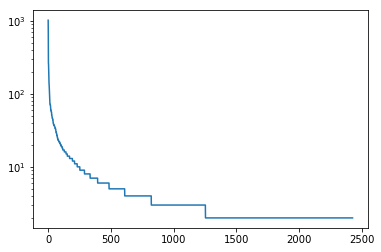

In [13]:
from natsort import natsorted
    
train_data_features = vec#X_train_counts.toarray()
vocab = ngramizer.get_feature_names()
dist = np.sum(train_data_features, axis=0)
ngram_freq = {}

# For each, print the vocabulary word and the frequency
for tag, count in zip(vocab, dist):
    #print(tag, count)
    ngram_freq[tag]=count

semilogy(natsorted(list(ngram_freq.values()),reverse=True))
show()

## WORD EMBEDDINGS

In [14]:
def _read_csv_we(filename = "data.csv"):
    
    embedding_index = {}

    for row in pd.read_csv(filepath_or_buffer=filename, sep = ' ', header=None).iterrows():
        word, coefs = row[1][0], np.asarray(row[1][1:])
        embedding_index[word] = coefs
        
    print('we vectors loaded from <'+filename+'>')
    print('\t'+str(len(embedding_index))+'\tentries')    
        
    return embedding_index


def _load_original_vectors(filename = 'wordvectors-glove.twitter.27B.100d.txt', sep = ' ', wordFrequencies = None):

    Dictionary, Indices  = {},{}
    i=1
    
    for line in open(filename, 'rb'): 
        values = line.decode('utf-8').split(sep)
        
        token = values[0]
        token_vector = np.array(values[1:], dtype = 'float32')   
        if(wordFrequencies):
            if(token in wordFrequencies):                
                Dictionary[token] = token_vector
                Indices.update({token:i})
                i+=1
        else:
            Dictionary[token] = token_vector
            Indices.update({token:i})
            i+=1
            
    print('we vectors loaded from <'+filename+'>')
    print('\t'+str(len(Dictionary))+' entries') 
    return(Dictionary, Indices)

def pretrainedEmbeddings(EmbeddingPath):
        embedding_index = {}
        
        with open(EmbeddingPath) as f:
            next(iter(f))
            embedding_wordsList = []
            for line in f:
                values = line.split(" ")
                word = values[0]
                coefs = np.asarray(values[1:])
                embedding_index[word] = coefs
                embedding_wordsList.append(word)
        
        return (embedding_index, embedding_wordsList)

def _texts_to_sequences(train_tweets):
    
    train_sequences = []
    for i,tweet in enumerate(train_tweets): 
        tw = []
        for token in tweet.split():
            try:
                tw.append(Indices[token])
            except:
                continue
        tw.extend([0]*( maxlen-len(tw)) )
        train_sequences.append(np.asarray(tw))
    return train_sequences

def _data_to_lists(dataTrain):    
    
    train_tweets, train_labels = [], []
    print('stacking data to lists')
    for i in dataTrain:
        scores = []
        for score in i[1:]:
            if np.isnan(score):
                scores.append( 0 )
                print('\tWarning: Nan value present in dataset')
            else:
                scores.append(score-2)
        train_labels.append(scores)
        train_tweets.append(i[0])
    print('data stacked to lists\n\t'+str(len(train_tweets))+' tweets\n\t'+str(len(train_labels))+' labels')
    return train_tweets, train_labelsprint(len(Dictionary),'tokens in we')

In [17]:
EMBEDDINGS_DIM = 100
WORD_FREQUENCY_TRESHOLD = 2

_path_wordembeddings = '/home/vlaand/data/Glove/glove.twitter.27B/glove.twitter.27B.'+str(EMBEDDINGS_DIM)+'d.txt'
# _path_wordembeddings = '/home/vlaand/data/Glove/glove.6B/glove.6B.100d.txt'

Dictionary, Indices = _load_original_vectors(
        filename = _path_wordembeddings, 
        sep = ' ',
        wordFrequencies = None)#wordFrequencies) # leave wordFrequencies=None for loading the entire WE file

Indices_reversed = {}
for key in Indices.keys():
    Indices_reversed.update({Indices[key]:key})

we vectors loaded from </home/vlaand/data/Glove/glove.twitter.27B/glove.twitter.27B.100d.txt>
	1193514 entries


In [ ]:


def dataframe_to_lists(df):

    train_tweets, train_labels = [], []

    for row in df.iterrows():
        train_tweets.append(row[1][1])
        train_labels.append(row[1][3])
        
    return train_tweets, train_labels

def lists_to_vectors(train_tweets, train_labels, embedding_matrix=None):

    train_sequences = _texts_to_sequences(train_tweets)
    
    if embedding_matrix==None:
        embedding_matrix = np.zeros((len(Indices)+1, EMBEDDINGS_DIM))

    print('matrix created\n\t',embedding_matrix.shape)
    for (word, i) in Indices.items():
        embedding_vector = Dictionary.get(word)
        if embedding_vector != None:
            embedding_matrix[i] = embedding_vector.astype(np.float)

    _X = sequence.pad_sequences(train_sequences, maxlen=maxlen)
    _y = np.array(train_labels)

    print(len(_X), 'train sequences loaded')
    print('\t',_X.shape,'\n\t', _y.shape)
    
    return _X, _y, embedding_matrix

def _get_maxlen(tweets):
    max = 0
    for tw in tweets:
        if len(tw.split()) > max:
            max = len(tw.split())
    return max

# Vector transformations

In [85]:
def _vectors_similarity(v1 , v2):
    return( 1 - spatial.distance.cosine(v1,v2) )
def similarityVector(vector_, vectors_):
    resVector = np.asarray([_vectors_similarity(vector_ , v_) for v_ in vectors_])
    return np.asarray([np.max(resVector), np.mean(resVector), np.std(resVector), np.min(resVector)])
def compareTokenToSentence(leftToken, sentence):
    sentence_vectors = []
    for token in sentence:
        if token in Dictionary:
            sentence_vectors.append(Dictionary[token])
        else:
            token = token.replace('#','')
            if token in Dictionary:
                sentence_vectors.append(Dictionary[token])
    return similarityVector( Dictionary[leftToken], sentence_vectors)  
def capitalRatio(tweet):
        firstCap, allCap = 0, 0
        length = len(tweet)
        if length==0:
            return np.array([0,0])
        for i,token in enumerate(tweet.split()):
            if( token.istitle() ):
                firstCap += 1
            elif( token.isupper() ):
                allCap += 1
        return np.asarray([firstCap/length,allCap/length]) 
def tweetToWordVectors(dictionary, tweet, fixedLength=False):
    output = []    
    if(fixedLength):
        for i in range(MAX_SEQUENCE_LENGTH):
            output.append(blankVector)
        for i,token in enumerate(tweet.split()):
            if token in Dictionary:
                output[i] = Dictionary[token]                
    else:
         for i,token in enumerate(tweet.lower().split()):
            if token in Dictionary:
                output.append(Dictionary[token])
            elif token.replace('#','') in Dictionary:
                output.append(Dictionary[token.replace('#','')])
    return output
def ModWordVectors(x, mod=True):
    if(len(x) == 0):       
        if(mod):
            return(np.zeros(EMBEDDINGS_DIM*3, dtype='float32'))
        else:
            return(np.zeros(EMBEDDINGS_DIM, dtype='float32'))        
    m =  np.matrix(x)
    if(mod):
        xMean = np.array(m.mean(0))[0]
        xMin = np.array(m.min(0))[0]
        xMax = np.array(m.max(0))[0]
        xX = np.concatenate((xMean,xMin,xMax))
        return xX
    else:
        return np.array(m.mean(0))[0]
def bindTwoVectors(x0,x1):
    return np.array(list(itertools.chain(x0,x1)),dtype='float32') 
def _bind_vectors(x):
    return np.concatenate(x)   
def myLog10(vector):
    for i,v in enumerate(vector):
        if v > 0:
            vector[i] = np.log(v)
    return vector            
def _convert_text_to_vector(tweets,  Dictionary, labels, ngramizer, lstmLayer=None, emotion = None):
    _X = []
    _y = []
    vec = ngramizer.transform(tweets).toarray()
    for i, t in enumerate(tweets):
        if lstmLayer==None:
            embeddingsVector = ModWordVectors(tweetToWordVectors(Dictionary,tweets[i]))
        else:
            embeddingsVector_lstm = lstmLayer[i]
            embeddingsVector = ModWordVectors(tweetToWordVectors(Dictionary,tweets[i]))
                
#         capitalRatioVector = capitalRatio(dfs[st][emoNames[EMOTION]][i])
#         simVector = compareTokenToSentence(leftToken = emoNames[EMOTION], sentence = t)

        ngramVector = vec[i]
#         _X.append( ngramVector )
#         _X.append(( _bind_vectors((ngramVector, embeddingsVector_lstm))  )
        _X.append( _bind_vectors((ngramVector,embeddingsVector))  )
        
        if emotion == None:
            _y.append( labels[i] )
        else:
            _y.append( labels[i][emotion] )
    return(np.asarray(_X), np.asarray(_y))


### Exctract activations
# for j,i in enumerate(lstmTrained.layers):
#     print(j,i)

# get_activations = function([lstmTrained.layers[0].input], lstmTrained.layers[1].output, allow_input_downcast=True)
# activations = get_activations(lstm_X_train) # same result as above

# SVM

In [86]:
normalize_labels = True
svc_X, svc_y = [[],[],[],[]], [[],[],[],[]]

for j, emo in enumerate(emoNames):
    EMOTION = j
    svc_X[j], svc_y[j] = _convert_text_to_vector(
        tweets = tweets_reduced,
        labels = labels, Dictionary = Dictionary, ngramizer = ngramizer,  
        emotion = EMOTION,
        lstmLayer = None#get_activations(lstm_X_train)        
    )
    if normalize_labels:
        svc_y[j] /= 4
    
    print('emotion:', emoNames[EMOTION])
    print('\t', svc_X[j].shape, svc_y[j].shape)  

emotion: confident
	 (2019, 2729) (2019,)
emotion: excited
	 (2019, 2729) (2019,)
emotion: happy
	 (2019, 2729) (2019,)
emotion: surprised
	 (2019, 2729) (2019,)


In [89]:
print("labels range: [%.1f : %.1f]" % (min(np.concatenate(svc_y)), max(np.concatenate(svc_y))))

labels range: [0.0 : 1.0]


## GridSearch

In [158]:
from sklearn.metrics import make_scorer

def scorer_pearson(ground_truth, predictions):
    return pearsonr(ground_truth, predictions)[0]

ftwo_scorer = make_scorer(scorer_pearson)
ftwo_scorer

make_scorer(scorer_pearson)

In [161]:
warnings.simplefilter('ignore')

ESTIMATOR = 'LinearSVR'
# ESTIMATOR = 'SVR'
cv_folds = 5

def _greed_search():     

    list_acc = []    
    list_val = []
                
    epsilon = 0.001    
    if(ESTIMATOR == 'LinearSVR'): 
        gamma_array = [1.0]
    elif(ESTIMATOR == 'SVR'):
        gamma_array = [0.001,0.01,0.1]
        
    c_array = [0.0001,0.001,0.01,0.1,1.0]
#     c_array = [0.0001]
    print("estimator, emotion, \tC, gamma, tol, score")

    for C in c_array:
        for gamma in gamma_array:              
            for tol in [1e-4]:
                cvs = cross_val_score(estimator = LinearSVR(C=C, tol=tol), X=svc_X[EMOTION], y=svc_y[EMOTION], cv=cv_folds, n_jobs=cv_folds, scoring=ftwo_scorer) 
                meanScore = np.mean(np.asarray(cvs))
                
#                 if(ESTIMATOR == 'LinearSVR'): 
#                     svcTrained = LinearSVR(C=C, tol=tol) 
#                 elif(ESTIMATOR == 'SVR'): 
#                     svcTrained = SVR(C=C, tol=tol,gamma=gamma) 
                    
#                 svcTrained.fit(svc_X[EMOTION], svc_y[EMOTION])

#                 meanScore = r2_score(svc_y[EMOTION] , svcTrained.predict(svc_X[EMOTION]))
#                 prs = pearsonr(svc_y_test , svc_y_test_predict)[0]
#                 spr = spearmanr(svc_y_test , svc_y_test_predict)[0]

                list_val.append([moduleName,meanScore,ESTIMATOR, C, gamma,epsilon,tol,NGRAM_VALUE,EMBEDDINGS_DIM])
                list_acc.append(meanScore)
        
                print('%s, %s, \t%s, %s, %s, %.4f' %(ESTIMATOR, emoNames[EMOTION], str(C), str(gamma), str(tol), meanScore))     
        
    best = np.argmax(list_acc)    
#     print(list_val[best])
    out0 = {
        'C':list_val[best][3], 
        'gamma': list_val[best][4],
        'epsilon': list_val[best][5],
        'tol': list_val[best][6],
        'ngrams': list_val[best][7],
        'EMBEDDINGS_DIM': list_val[best][8],
        'score': list_val[best][1]
    }
    return {ESTIMATOR:{emoNames[EMOTION]:out0}}

    
def _combine_best_results(pool_output, ESTIMATOR):
    new_p = {}       
    for i in pool_output:
        new_p.update(i)   
        
    return new_p  

EMOTION = 2
pool_output = [_greed_search()]

print()
print(pool_output[0])

estimator, emotion, 	C, gamma, tol, score
LinearSVR, happy, 	0.0001, 1.0, 0.0001, 0.4259
LinearSVR, happy, 	0.001, 1.0, 0.0001, 0.5680
LinearSVR, happy, 	0.01, 1.0, 0.0001, 0.5868
LinearSVR, happy, 	0.1, 1.0, 0.0001, 0.4964
LinearSVR, happy, 	1.0, 1.0, 0.0001, 0.3574

{'LinearSVR': {'happy': {'C': 0.01, 'gamma': 1.0, 'epsilon': 0.001, 'tol': 0.0001, 'ngrams': 4, 'EMBEDDINGS_DIM': 100, 'score': 0.58676167845815486}}}


In [147]:
temp_params = _combine_best_results(pool_output, ESTIMATOR)

try:
    train_params[ESTIMATOR].update(temp_params[ESTIMATOR])
except:
    train_params = {}
    train_params.update(temp_params)
    
train_params

{'LinearSVR': {'confident': {'C': 0.01,
   'EMBEDDINGS_DIM': 100,
   'epsilon': 0.001,
   'gamma': 1.0,
   'ngrams': 4,
   'score': 0.08006788917747884,
   'tol': 0.0001},
  'excited': {'C': 0.01,
   'EMBEDDINGS_DIM': 100,
   'epsilon': 0.001,
   'gamma': 1.0,
   'ngrams': 4,
   'score': 0.20181656813534418,
   'tol': 0.0001},
  'happy': {'C': 0.01,
   'EMBEDDINGS_DIM': 100,
   'epsilon': 0.001,
   'gamma': 1.0,
   'ngrams': 4,
   'score': 0.31076973883989167,
   'tol': 0.0001},
  'surprised': {'C': 0.001,
   'EMBEDDINGS_DIM': 100,
   'epsilon': 0.001,
   'gamma': 1.0,
   'ngrams': 4,
   'score': -0.021827945233623081,
   'tol': 0.0001}}}

In [104]:
train_params = {
    'LinearSVR': {
        'confident': {'C': 0.01,
            'EMBEDDINGS_DIM': 100,
            'epsilon': 0.001,
            'gamma': 1.0,
            'ngrams': 4,
            'score': 0.08006788917747884,
            'tol': 0.0001},
        'excited': {'C': 0.01,
            'EMBEDDINGS_DIM': 100,
            'epsilon': 0.001,
            'gamma': 1.0,
            'ngrams': 4,
            'score': 0.20181656813534418,
            'tol': 0.0001},
        'happy': {'C': 0.01,
            'EMBEDDINGS_DIM': 100,
            'epsilon': 0.001,
            'gamma': 1.0,
            'ngrams': 4,
            'score': 0.31076973883989167,
            'tol': 0.0001},
        'surprised': {'C': 0.001,
            'EMBEDDINGS_DIM': 100,
            'epsilon': 0.001,
            'gamma': 1.0,
            'ngrams': 4,
            'score': -0.021827945233623081,
            'tol': 0.0001}}}

## SAVE CLASSIFIERS

In [162]:
# ESTIMATOR = 'SVR'
ESTIMATOR = 'LinearSVR'

if ESTIMATOR == 'SVR':
    svcTrained = SVR(C=train_params[ESTIMATOR][emoNames[EMOTION]]['C'], 
                 tol=train_params[ESTIMATOR][emoNames[EMOTION]]['tol'], 
                 gamma=train_params[ESTIMATOR][emoNames[EMOTION]]['gamma'],
                 verbose=True)
    
else:
    svcTrained = LinearSVR(C=train_params[ESTIMATOR][emoNames[EMOTION]]['C'], 
                 tol=train_params[ESTIMATOR][emoNames[EMOTION]]['tol'], 
                 verbose=True)
    
svcTrained.fit(svc_X[EMOTION], svc_y[EMOTION])
print(svcTrained)

       
# def saveModelFor(model, ESTIMATOR, path='/home/vlaand/IpythonNotebooks/wassa2017/'):
#     path = os.path.join(path,ESTIMATOR)
#     checkFolder(path)
#     filename = path+'.dump'
#     checkFolder(filename)
#     _ = joblib.dump(model, filename, compress=9)
#     print("model saved to <%s>" % filename)
    
# saveModelFor(svcTrained, ESTIMATOR=ESTIMATOR, path = os.path.join(repositoryPath, moduleName, 'classifiers'))

ValueError: Found array with dim 3. Estimator expected <= 2.

In [106]:
from sklearn.svm import SVR, LinearSVR
from sklearn.externals import joblib
from multiprocessing import Pool
import os, sys

SEP = '/'
EXTENSION = '.dump'
ESTIMATOR = 'LinearSVR'
SAVE_DIR = '/home/vlaand/IpythonNotebooks/senpy-plugins-NUIG/fivePointRegression/classifiers/'

def ifExists(filename):
    dir = os.path.dirname(filename)
    try:
        os.stat(dir)
    except:
        os.mkdir(dir) 

def trainModelFor(EMOTION):
    
    y2 = []
    for ly in y:  
        if not np.isnan(ly[EMOTION]):        
            y2.append(float(ly[EMOTION])/4)
        else:
            y2.append(2.0)
        
    y2 = np.asarray(y2)    
    C = train_params[ESTIMATOR][ emoNames[EMOTION] ]['C'] 
    tol = train_params[ESTIMATOR][ emoNames[EMOTION] ]['tol'] 
                   
    if(ESTIMATOR == 'SVR'):
        gamma = train_params[ESTIMATOR][ emoNames[EMOTION] ]['gamma'] 
        svcTrained = SVR(C=C, gamma=gamma, tol=tol) 
        svcTrained.fit(X2, y2)
    elif(ESTIMATOR == 'LinearSVR'):
        svcTrained = LinearSVR(C=C, tol=tol)
        svcTrained.fit(X2, y2)
    else:
        print('Error: Classifier is not chosen')
        sys.exit(0)
        
    return(svcTrained)

def checkFolder(filename):
    dir = os.path.dirname(filename)
    try:
        os.stat(dir)
    except:
        os.mkdir(dir) 

def saveModelFor(model, EMOTION):
    path = SAVE_DIR +ESTIMATOR
    checkFolder(path)
    filename = path + SEP +str(emoNames[EMOTION]) + EXTENSION
    checkFolder(filename)
    _ = joblib.dump(model, filename, compress=9)
    print('model ' + filename + ' saved')
    #return {emoNames[EMOTION]:model}
    
def trainAndSave(emotion):
    model = trainModelFor(emotion)
    saveModelFor(model=model, EMOTION=emotion)
    return {emoNames[emotion]:model}

def _combine_train_results(pool_output, ESTIMATOR):
    new_p = {ESTIMATOR:{}}   
    for i in pool_output:
        new_p[ESTIMATOR].update(i)
        
    return new_p    

X2 = np.asarray(X) 
with Pool(processes = len(emoNames)) as p:
    pool_output = p.map(trainAndSave, [i for i in  range(len(emoNames))])


temp_models = _combine_train_results(pool_output, ESTIMATOR)

try:
    train_models.update(temp_models)
except:
    train_models = temp_models

NameError: name 'X' is not defined

In [227]:
l0,l1,l2 = [],[],[]
y0,y1,y2 = [],[],[]

for i,y_ in enumerate(y):
#     print(y_/4, y_pred[0][i], y_pred[1][i], y_pred[2][i])
    y_0,y_1,y_2 = y_pred[0][i],y_pred[1][i],y_pred[2][i]
    
    l0.append(y_0)    
    l1.append(y_1)
    l2.append(y_2)
        
    y0.append(y_[0]/4)
    y1.append(y_[1]/4)
    if not np.isnan(y_[2]/4):
        y2.append(y_[2]/4)
    else:
        print('!')
        y2.append(0.5)
#     print(i/4, j[0], j[1], j[2])
              
r2_score(y0,l0),r2_score(y1,l1),r2_score(y2,l2)


NameError: name 'y_pred' is not defined

## Comparison HTC-VAD    &    FPR

In [40]:
models_path_fpr = '/home/vlaand/IpythonNotebooks/senpy-plugins-development/fivePointRegression/classifiers/SVR/'

models_fpr = {}
for emo in emoNames:
    models_fpr.update({emo:joblib.load(models_path_fpr+emo+'.dump')})
    
# models_fpr

In [9]:
models_path_htc = '/home/vlaand/IpythonNotebooks/senpy-plugins-NUIG/hashTagClassification/classifiers/LinearSVR/'

models_htc = {}
for emo in ['sadness', 'disgust', 'surprise', 'anger', 'fear', 'joy']:
    models_htc.update({emo:joblib.load(models_path_htc+emo+'.dump')})
    
# models_htc

In [215]:
models_path_htc_rbf = '/home/vlaand/IpythonNotebooks/senpy-plugins-NUIG/hashTagClassification/classifiers/SVC/'

models_htc_rbf = {}
for emo in ['sadness', 'disgust', 'surprise', 'anger', 'fear', 'joy']:
    models_htc_rbf.update({emo:joblib.load(models_path_htc_rbf+emo+'.dump')})
    
# models_htc_rbf

In [18]:
Dictionary
# wordFrequencies
# ngramizer

In [10]:
def _load_unique_tokens(filename = 'wordFrequencies.dump'):

#     filename = os.path.join(os.path.dirname(__file__),filename)
    return(joblib.load(filename))

wordFrequencies = _load_unique_tokens('/home/vlaand/IpythonNotebooks/senpy-plugins-NUIG/hashTagClassification/wordFrequencies.dump')

In [11]:
def foo():
    ngramizers = []
    for n_grams in [2,3,4]:        
        filename = os.path.join('/home/vlaand/IpythonNotebooks/senpy-plugins-NUIG/hashTagClassification/ngramizers/', str(n_grams)+'gramizer.dump')
        ngramizers.append( joblib.load(filename) )
        
    return ngramizers

ngramizers = foo()

In [121]:
# ngramizer = joblib.load('/home/vlaand/IpythonNotebooks/senpy-plugins-NUIG/hashTagClassification/ngramizers/4gramizer.dump')

In [14]:
import pandas as pd

dataTrain = _read_csv_data(filename = _path_dataset, header=True)    
print('training data loaded from <'+_path_dataset+'>')

train_tweets = []
train_labels = []

for i in dataTrain:
    scores = []
    for score in i[1:]:
        if(np.isnan(score)):
            scores.append(2.0)
        else:
            scores.append(score)
    train_labels.append(scores)
    train_tweets.append(i[0])

training data loaded from </home/vlaand/IpythonNotebooks/cf-5point-data/data-full.csv>


In [15]:
_ngramVectors = []

for i in ngramizers:
    _ngramVectors.append(i.transform(train_tweets).toarray())

In [16]:
X_eval_2, y_eval = _convert_text_to_vector(tweets = train_tweets, tweet_original = train_tweets, Dictionary = Dictionary, labels = train_labels, ngramvec =_ngramVectors[0])
X_eval_3, y_eval = _convert_text_to_vector(tweets = train_tweets, tweet_original = train_tweets, Dictionary = Dictionary, labels = train_labels, ngramvec =_ngramVectors[1])
X_eval_4, y_eval = _convert_text_to_vector(tweets = train_tweets, tweet_original = train_tweets, Dictionary = Dictionary, labels = train_labels, ngramvec =_ngramVectors[2])

print(X_eval_2.shape,X_eval_3.shape,X_eval_4.shape)
print(y_eval.shape)

(2019, 16169) (2019, 18241) (2019, 19192)
(2019, 3)


In [ ]:
X = {'sadness':X4, 'disgust':X4, 'surprise':X4, 'anger':X2, 'fear':X4, 'joy':X3}

### Predicts to VAD

In [24]:
y_pred_htc = {}

for emo in ['sadness', 'disgust', 'surprise', 'anger', 'fear', 'joy']:
    if emo == 'anger':
        y_pred_htc.update({emo:models_htc[emo].predict(X_eval_2)})
    elif emo == 'joy':
        y_pred_htc.update({emo:models_htc[emo].predict(X_eval_3)})
    else:
        y_pred_htc.update({emo:models_htc[emo].predict(X_eval_4)})
        
features_htc = {}
for dimension in ['V','A','D']:
    values = []
    for row in range(len(y_pred_htc['surprise'])):
        weights=[y_pred_htc[i][row] for i in y_pred_htc if (i != 'surprise')]
        if False in all(v == 0 for v in weights):
            values.append(np.average([centroids[i][dimension] for i in y_pred_htc if (i != 'surprise')], weights=weights ))
        else:
            values.append(5.0)            
    features_htc.update({dimension:values})   
    
features_htc

In [ ]:
y_pred_htc_rbf = {}
for emo in ['sadness', 'disgust', 'surprise', 'anger', 'fear', 'joy']:
    print(emo)
    if emo == 'anger':
        y_pred_htc_rbf.update({emo:models_htc_rbf[emo].predict_proba(X_eval_2)})
    elif emo == 'joy':
        y_pred_htc_rbf.update({emo:models_htc_rbf[emo].predict_proba(X_eval_3)})
    else:
        y_pred_htc_rbf.update({emo:models_htc_rbf[emo].predict_proba(X_eval_4)})


1
sadness


In [232]:
features_htc_rbf = {}
for dimension in ['V','A','D']:
    print(dimension)
    values = []
    for row in range(len(y_pred_htc_rbf['surprise'])):
        weights=[y_pred_htc_rbf[i][row][1] for i in y_pred_htc_rbf if (i != 'surprise')]
#         if False in all(v == 0 for v in weights):
        values.append(np.average([centroids[i][dimension] for i in y_pred_htc_rbf if (i != 'surprise')], weights=weights ))
#         else:
#             values.append(5.0)            
    features_htc_rbf.update({dimension:values})   
    
# features_htc_rbf

V
A
D


In [119]:
y_pred_fpr = {}

for emo in emoNames:
    y_pred_fpr.update({emo:10*models_fpr[emo].predict(X_eval_4)})
    
y_pred_fpr

{'confident': array([ 5.99784253,  6.03535934,  6.03450945, ...,  6.03278388,
         6.01940154,  6.04865325]),
 'excited': array([ 6.04721026,  6.13505352,  6.21766691, ...,  6.17532646,
         6.14233364,  6.31161089]),
 'happy': array([ 4.67336817,  4.32912562,  4.62225976, ...,  5.25173427,
         4.73891756,  5.04414936])}

In [155]:
y_annotated = {'V':y_eval.T[0]*10/4, 'A':y_eval.T[1]*10/4 ,'D':y_eval.T[2]*10/4}

In [ ]:
vad_mappings = {
     'confident': 'D',
     'excited': 'A',
     'happy': 'V',
     'D':'confident',
     'A':'excited',
     'V':'happy'
}

In [233]:
for i,dimension in enumerate(['V','A','D']):
    print( 
        r2_score(   features_htc[dimension],               y_annotated[dimension]               ),
        r2_score(   y_pred_fpr[vad_mappings[dimension]],   y_annotated[dimension]               ),
        r2_score(   features_htc_rbf[dimension],           y_annotated[dimension]               )
        )

-0.620680748396 -19.4727733044 -1.75307874052
-2.27833304462 -29.496527739 -14.8417019805
-1.56540913825 -22311.4709413 -9.50414297565


# PLOT

Populating the interactive namespace from numpy and matplotlib


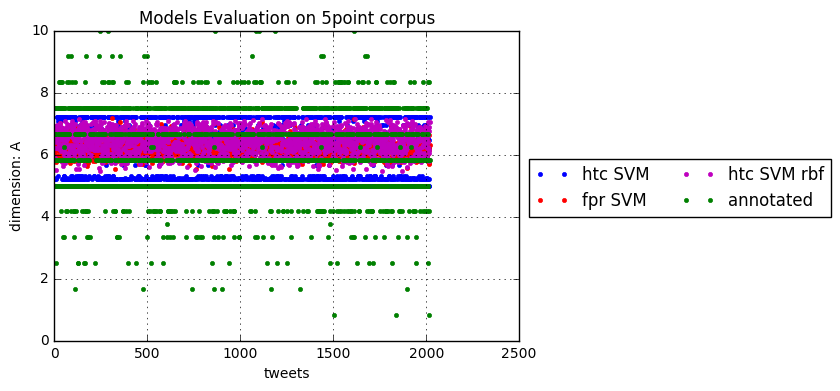

In [280]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import natsort

tmp_range = 2018
dimension = 'A'

s = y_annotated[dimension]
order = sorted(range(len(s)), key=lambda k: s[k])

g0 = [i for i in range(2019)]
g1 = features_htc[dimension]
g2 = y_pred_fpr[vad_mappings[dimension]] 
g3 = features_htc_rbf[dimension]
g4 = y_annotated[dimension]
    
plt.grid(True)
# plt.plot(g1[0:tmp_range], 'r', g2[0:tmp_range], 'b', g3[0:tmp_range], 'g')
# plt.legend()
# plt.show()


line_0, = plt.plot(np.array(g1)[], 'b.',  label='htc SVM')
line_1, = plt.plot(np.array(g2)[order], 'r.', label='fpr SVM')
line_2, = plt.plot(np.array(g3)[order], 'm.', label='htc SVM rbf')
line_3, = plt.plot(np.array(g4)[order], 'g.', label='annotated')
# plt.plot([0,l],[.3,.3])
# plt.plot([0,l],[-.3,-.3])
plt.legend(handles=[line_0, line_2, line_1, line_3])
plt.legend(bbox_to_anchor=(1.02, .4, .65, .0), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
# plt.legend(bbox_to_anchor=(0.6, 0.05, 0.35, .102), loc=4,
#            ncol=1, mode="expand", borderaxespad=0.)

plt.ylabel('dimension: '+dimension)
plt.xlabel('tweets')
plt.title("Models Evaluation on 5point corpus")
plt.show()

In [ ]:
feature_set_ftr = {emo: clf.predict_proba(X[emo]) for emo,clf in zip(emoNames, classifiers[estimator])}

# feature_set_htc = {emo: clf.predict(X[emo]) for emo,clf in zip(['sadness', 'disgust', 'surprise', 'anger', 'fear', 'joy'], classifiers[estimator])} 
            

In [22]:
centroids= {
                            "anger": {
                                "A": 6.95, 
                                "D": 5.1, 
                                "V": 2.7
                            }, 
                            "disgust": {
                                "A": 5.3, 
                                "D": 8.05, 
                                "V": 2.7
                            }, 
                            "fear": {
                                "A": 6.5, 
                                "D": 3.6, 
                                "V": 3.2
                            }, 
                            "joy": {
                                "A": 7.22, 
                                "D": 6.28, 
                                "V": 8.6
                            }, 
                            "sadness": {
                                "A": 5.21, 
                                "D": 2.82, 
                                "V": 2.21
                            },
                            "neutral": {
                                "A": 5.0, 
                                "D": 5.0, 
                                "V": 5.0
                            }
                        }

# LSTM

In [250]:
import numpy as np
import pandas as pd
import csv

from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Bidirectional, Dropout, LSTM
from keras.regularizers import l2

from imblearn.over_sampling import RandomOverSampler
from sklearn.cross_validation import StratifiedKFold

In [182]:
def _read_csv_data(filename = "data.csv", header=True):
    
    df = pd.read_csv(filepath_or_buffer = filename)     
    print('data loaded from <'+filename+'>')
    print('\t'+str(len(df))+' entries')    
    
    tweets_list = []    
    for row in df.iterrows():
        tweets_list.append([tokenise_tweet(row[1]['tweet'])] +[row[1][emo]for emo in emoNames])   
    return tweets_list

def _read_csv_we(filename = "data.csv"):
    
    embedding_index = {}

    for row in pd.read_csv(filepath_or_buffer=filename, sep = ' ', header=None).iterrows():
        word, coefs = row[1][0], np.asarray(row[1][1:])
        embedding_index[word] = coefs
        
    print('we vectors loaded from <'+filename+'>')
    print('\t'+str(len(embedding_index))+'\tentries')    
        
    return embedding_index


def _load_original_vectors(filename = 'glove.27B.100d.txt', sep = ' ', wordFrequencies = None, zipped = False):
       
        def __read_file(f):
            Dictionary, Indices  = {},{}
            i = 1
            for line in f:
                line_d = line.decode('utf-8').split(sep)

                token = line_d[0]
                token_vector = np.array(line_d[1:], dtype = 'float32')   
                if(wordFrequencies):
                    if(token in wordFrequencies):                
                        Dictionary[token] = token_vector
                        Indices.update({token:i})
                        i+=1
                else:
                    Dictionary[token] = token_vector
                    Indices.update({token:i})
                    i+=1
            return(Dictionary, Indices)
            
        if zipped:
            with gzip.open(filename, 'rb') as f:
                return(__read_file(f))
        else:
            with open(filename, 'rb') as f:
                return(__read_file(f))

        
#         return(Dictionary, Indices)

def _texts_to_sequences(train_tweets):
    
    train_sequences = []
    for i,tweet in enumerate(train_tweets): 
        tw = []
        for token in tweet.split():
            try:
                tw.append(Indices[token])
            except:
                continue
        tw.extend([0]*( maxlen-len(tw)) )
        train_sequences.append(np.asarray(tw))
    return train_sequences

def _data_to_lists(dataTrain):    
    
    train_tweets, train_labels = [], []
    print('stacking data to lists')
    for i in dataTrain:
        scores = []
        for score in i[1:]:
            if np.isnan(score):
                scores.append( 0 )
                print('\tWarning: Nan value present in dataset')
            else:
                scores.append(score-2)
        train_labels.append(scores)
        train_tweets.append(i[0])
    print('data stacked to lists\n\t'+str(len(train_tweets))+' tweets\n\t'+str(len(train_labels))+' labels')
    return train_tweets, train_labels

def _get_maxlen(tweets):
    max = 0
    for tw in tweets:
        if len(tw.split()) > max:
            max = len(tw.split())
    return max

In [241]:
seed = 1337
np.random.seed(seed)

maxlen = 65
batch_size = 32
EMBEDDINGS_DIM = 100
epochs = 50

hidden_dims1 = 50
hidden_dims2 = 25
hidden_dims3 = 3

path = '/home/vlaand/IpythonNotebooks/cf-5point-data/'

_path_wordembeddings = '/home/vlaand/data/Glove/glove.twitter.27B/glove.twitter.27B.'+str(EMBEDDINGS_DIM)+'d.txt'
_path_dataset = path + "data-full5.csv"

### Load training data and word embeddinbgs

In [242]:
dataTrain = _read_csv_data(filename = _path_dataset, header=True)  

train_tweets, train_labels = _data_to_lists(dataTrain)

data loaded from </home/vlaand/IpythonNotebooks/cf-5point-data/data-full5.csv>
	2019 entries
stacking data to lists
data stacked to lists
	2019 tweets
	2019 labels


In [243]:
wordFrequencies = _get_unique_tokens(train_tweets)
# _plot_word_frequencies(wordFrequencies, WORD_FREQUENCY_TRESHOLD = WORD_FREQUENCY_TRESHOLD)

Dictionary, Indices = _load_original_vectors(
        filename = '/home/vlaand/data/Glove/glove.twitter.27B/glove.twitter.27B.'+str(EMBEDDINGS_DIM)+'d.txt', 
        sep = ' ', 
        wordFrequencies=None,
        zipped=False)

In [244]:
train_sequences = _texts_to_sequences(train_tweets)

embedding_matrix = np.zeros((len(Indices)+1, EMBEDDINGS_DIM))

print('matrix created\n\t',embedding_matrix.shape)
for (word, i) in Indices.items():
    embedding_vector = Dictionary.get(word)
    if (embedding_vector != None):
        embedding_matrix[i] = embedding_vector.astype(np.float)

X = sequence.pad_sequences(train_sequences, maxlen=maxlen)
y = np.array(train_labels)

print(len(X), 'train sequences loaded')
print('\t',X.shape,'\n\t', y.shape)

matrix created
	 (1193515, 100)


/home/vlaand/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


2019 train sequences loaded
	 (2019, 65) 
	 (2019, 4)


In [334]:
if (np.min(y), np.max(y)) != (0.0, 1.0):
    y = (y+2)/4
    print('labels normalized',(np.min(y), np.max(y)))
else:
    print('already normalized',(np.min(y), np.max(y)))

already normalized (0.0, 1.0)


## Evaluation / Cross validation



### Kfold cross-validation

In [66]:
from multiprocessing import Pool
from sklearn.metrics import r2_score
import os

epochs = 20
n_splits = 5

def _cross_validation_parallel(_input):
    train, test = _input
    
    model = Sequential()
    model.add(Embedding(len(Indices)+1,  EMBEDDINGS_DIM, weights=[embedding_matrix],
                                input_length=maxlen, trainable=False))
    model.add(Bidirectional(LSTM(EMBEDDINGS_DIM)))
    #model.add(Dropout(0.2))
    model.add(Dense(hidden_dims1, kernel_regularizer=l2(0.01)), )
    model.add(Dense(hidden_dims2, kernel_regularizer=l2(0.01)), ) 
    model.add(Dense(hidden_dims3, activation='elu'))

    model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])

    model.fit(X[train], y[train], batch_size=batch_size, epochs=epochs, validation_split=None, verbose=0)

    scores = []
    for i in [0,1,2]:
        score = r2_score( y[test][:, i] , model.predict(X[test])[:, i] )
        #score = r2_score([y_[i] for y_ in y[test]], [y_[i] for y_ in model.predict(X[test])])
        print("R2["+emoNames[i]+"]\t"+str(score))
        scores.append(score)        
    return scores

seed = 1337
np.random.seed(seed)

kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

with Pool(processes = n_splits) as p:
    cvscores = p.map(_cross_validation_parallel, [(train, test) for (train, test) in kfold.split(X, [yy[0] for yy in y])])

/home/vlaand/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


R2[confident]	0.12651473344
R2[excited]	0.183913593432
R2[happy]	0.325849621671
R2[confident]	0.114282643682
R2[excited]	0.280324333738
R2[happy]	0.33475915174
R2[confident]	0.0799940323227
R2[excited]	0.297428340739
R2[happy]	0.427131191301
R2[confident]	0.115380225651
R2[excited]	0.318680321749
R2[happy]	0.245129420541
R2[confident]	0.12899566559
R2[excited]	0.276562234678
R2[happy]	0.34378839584


In [68]:
print("%d-fold cross validation\n" % (n_splits))
for i in [0,1,2]:
    print("R2[%s] \t%.4f (+/- %.2f)" % (emoNames[i], np.mean(cvscores,axis=0)[i], np.std(cvscores,axis=0)[i]))

5-fold cross validation

R2[confident] 	0.1130 (+/- 0.02)
R2[excited] 	0.2714 (+/- 0.05)
R2[happy] 	0.3353 (+/- 0.06)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.cross_validation import StratifiedKFold

from sklearn.metrics import r2_score, f1_score, classification_report
# from skll.metrics import pearsonr, spearman
from scipy.stats import pearsonr, spearmanr

from multiprocessing import Pool, Manager
import os
import numpy as np

def _cross_validation_parallel(_input):
    train, test = _input
    
    model = Sequential()
    model.add(Embedding(len(Indices)+1,  EMBEDDINGS_DIM, weights=[embedding_matrix],
                                input_length=maxlen, trainable=False))
    model.add(Bidirectional(LSTM(EMBEDDINGS_DIM))) #dropout is same as regularisation
    model.add(Dropout(0.2))
    model.add(Dense(hidden_dims1, W_regularizer=l2(0.01)), )
    model.add(Dense(hidden_dims2, W_regularizer=l2(0.01)), ) #!!!
    model.add(Dense(hidden_dims3, activation='softsign'))
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy', matthews_correlation])
        
    model.fit(X[train], y[train], batch_size=batch_size, nb_epoch=nb_epoch, validation_split=None)
    
#     scores = model.evaluate(X[test], y[test], verbose=0,)
    y_test_predict = model.predict(X[test])
#     y_test_predict = np.reshape(y_test_predict, newshape=(len(y_test_predict),))
    
    scores =  [
                [r2_score(y_test_predict[:,emo], y[test][:,emo]) for emo in [0,1,2,3]], 
                [pearsonr(y_test_predict[:,emo], y[test][:,emo]) for emo in [0,1,2,3]], 
                [spearmanr(y_test_predict[:,emo], y[test][:,emo]) for emo in [0,1,2,3]]
              ]
#     try:
#         print("%s: %.2f" % (model.metrics_names[2], scores[1]))
#     except:
#         print('Error')
    return scores

nb_epoch = 80
n_splits = 5
hidden_dims1, hidden_dims2, hidden_dims3 = 50, 25, 4
np.random.seed(1337)

# with open('senpy-plugins-development/fivePointRegression/classifiers/LSTM/log.out', "w") as log_file:
#     log_file.write(str(cvscores)+'\n')
#     log_file.write("%.2f (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

In [ ]:
kfold = StratifiedKFold(n_folds=n_splits, shuffle=True, random_state=1337, y=y[:,0])

with Pool(processes = n_splits) as p:
    cvscores = p.map(_cross_validation_parallel, ((train, test) for (train, test) in kfold))

/home/vlaand/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


Epoch 1/80
 448/1618 [=======>......................] - ETA: 52s - loss: 1.5245 - acc: 0.4576 - matthews_correlation: 0.2409

In [196]:
print('\t\tR2\tsd\tpearson\tsd\tspearman')
for emo in [0,1,2,3]:

    r2 = [n[emo] for n in [fold[0] for fold in cvscores]]
    prs = [n[emo][0] for n in [fold[1] for fold in cvscores]]
    spr = [n[emo][0] for n in [fold[2] for fold in cvscores]]

    print("[%8s]\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f" % (emoNames[emo],
                                 np.mean(r2), np.std(r2)/np.sqrt(n_splits),
                                 np.mean(prs), np.std(prs)/np.sqrt(n_splits),
                                 np.mean(spr), np.std(spr)/np.sqrt(n_splits)
                                          ))    
    

		R2	sd	pearson	sd	spearman
[confident]	-0.62	0.09	0.44	0.02	0.43	0.01
[ excited]	-0.65	0.04	0.52	0.01	0.52	0.00
[   happy]	-0.14	0.05	0.62	0.02	0.62	0.02
[surprised]	-1.68	0.09	0.29	0.01	0.28	0.02


In [176]:
p._pool[0].is_alive()

False

## Training

### Train / test split

In [336]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('shapes of training data and label tensors:', X_train.shape, y_train.shape)
print('shapes of testing data and label tensors:', X_test.shape, y_test.shape)

shapes of training data and label tensors: (1615, 65) (1615, 4)
shapes of testing data and label tensors: (404, 65) (404, 4)


In [21]:
# set(y for y in y_train.flat)

In [26]:
# kfold = StratifiedKFold(n_folds=5, shuffle=True, random_state=seed,y=y)

#### Custom Metrics

In [337]:
import keras.backend as K

def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [338]:
hidden_dims1 = 50
hidden_dims2 = 25
hidden_dims3 = 4

model = Sequential()
model.add(Embedding(len(Indices)+1,  EMBEDDINGS_DIM, weights=[embedding_matrix],
                            input_length=maxlen, trainable=False))
model.add(Bidirectional(LSTM(EMBEDDINGS_DIM))) #dropout is same as regularisation

model.add(Dropout(0.2))
model.add(Dense(hidden_dims1, b_regularizer=l2(0.01)),)
model.add(Dense(hidden_dims2, b_regularizer=l2(0.01)), ) 
model.add(Dense(hidden_dims3, activation='softsign'))

model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy',matthews_correlation])

In [339]:
nb_epoch = 20
model.fit(X, y, batch_size=batch_size, nb_epoch=nb_epoch, validation_split=None)

Epoch 1/20
2019/2019 [==============================] - 21s - loss: 0.1428 - acc: 0.4210 - matthews_correlation: 0.2000    
Epoch 2/20
2019/2019 [==============================] - 20s - loss: 0.1125 - acc: 0.4631 - matthews_correlation: 0.3472    
Epoch 3/20
2019/2019 [==============================] - 20s - loss: 0.1072 - acc: 0.4715 - matthews_correlation: 0.3852    
Epoch 4/20
2019/2019 [==============================] - 20s - loss: 0.1011 - acc: 0.5057 - matthews_correlation: 0.4427    
Epoch 5/20
2019/2019 [==============================] - 20s - loss: 0.0968 - acc: 0.4943 - matthews_correlation: 0.4517    
Epoch 6/20
2019/2019 [==============================] - 20s - loss: 0.0961 - acc: 0.5097 - matthews_correlation: 0.4445    
Epoch 7/20
2019/2019 [==============================] - 20s - loss: 0.0930 - acc: 0.5324 - matthews_correlation: 0.4795    
Epoch 8/20
2019/2019 [==============================] - 20s - loss: 0.0897 - acc: 0.5379 - matthews_correlation: 0.4953    
Epoch 9/

In [325]:
from sklearn.metrics import r2_score, f1_score, classification_report
# from skll.metrics import pearson, spearman
from scipy.stats import pearsonr, spearmanr


print('\t\tR2\tpearson\tspearman')
y_test_predicts = []
for i in range(20):
    if i>0: 
        model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=1,validation_split=None,)
#         model.fit(X, y, batch_size=batch_size, nb_epoch=1, validation_split=None)
    y_test_pred = np.array( model.predict(X_test))
    print("%8s\t%.2f\t%.2f\t%.2f" % (i,
                                 np.mean([r2_score(y1,y2)for y1,y2 in zip(y_test, y_test_pred)]) ,                                 
                                 np.mean([pearsonr(y1,y2)[0]  for y1,y2 in zip(y_test, y_test_pred)]) ,
                                 np.mean([spearmanr(y1,y2)[0]  for y1,y2 in zip(y_test, y_test_pred)])
                                    ))    
    y_test_predicts.append(y_test_pred)


# model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch,validation_split=None,)

		R2	pearson	spearman
       0	-3.19	0.02	0.01
Epoch 1/1
1413/1413 [==============================] - 14s - loss: 0.4674 - acc: 0.4529 - matthews_correlation: 0.2539    
       1	-1.39	0.56	0.50
Epoch 1/1
1413/1413 [==============================] - 14s - loss: 0.4290 - acc: 0.4883 - matthews_correlation: 0.3599    
       2	-1.05	0.57	0.50
Epoch 1/1
1413/1413 [==============================] - 13s - loss: 0.4050 - acc: 0.4890 - matthews_correlation: 0.4193    
       3	-1.05	0.59	0.52
Epoch 1/1
1413/1413 [==============================] - 14s - loss: 0.3923 - acc: 0.4862 - matthews_correlation: 0.4674    
       4	-0.92	0.59	0.52
Epoch 1/1
1413/1413 [==============================] - 14s - loss: 0.3811 - acc: 0.5053 - matthews_correlation: 0.4823    
       5	-0.71	0.59	0.53
Epoch 1/1
1413/1413 [==============================] - 14s - loss: 0.3751 - acc: 0.5159 - matthews_correlation: 0.5019    
       6	-0.66	0.60	0.54
Epoch 1/1
1413/1413 [==============================] - 14s - loss

In [2]:
print('[%8s]\tR2\tpearson\tspearman' % emoNames[EMOTION])
for i,y__ in enumerate(y_test_predicts): 
#         print("%8s\t%.2f\t%.2f\t%.2f" % (i,
#                                  r2_score(y_dev , y_test_predict),                                 
#                                  pearsonr(y_dev , y_test_predict)[0],
#                                  spearmanr(y_dev , y_test_predict)[0]))
        print("%8s\t%.2f\t%.2f\t%.2f" % (i,
                                 np.mean([r2_score(y1,y2)for y1,y2 in zip(y_test, y__)]) ,                                 
                                 np.mean([pearsonr(y1,y2)[0]  for y1,y2 in zip(y_test, y__)]) ,
                                 np.mean([spearmanr(y1,y2)[0]  for y1,y2 in zip(y_test, y__)])))

In [350]:
from sklearn.metrics import r2_score, f1_score, classification_report

y_test_predict = model.predict(X_test)
   
for i in [0,1,2,3]:
    print("[%9s]\t%.2f" % (emoNames[i],
                           r2_score(
                                y_test[: , i], 
                                y_test_predict[: , i]
                                )))

[confident]	0.96
[  excited]	0.94
[    happy]	0.96
[surprised]	0.93


Populating the interactive namespace from numpy and matplotlib


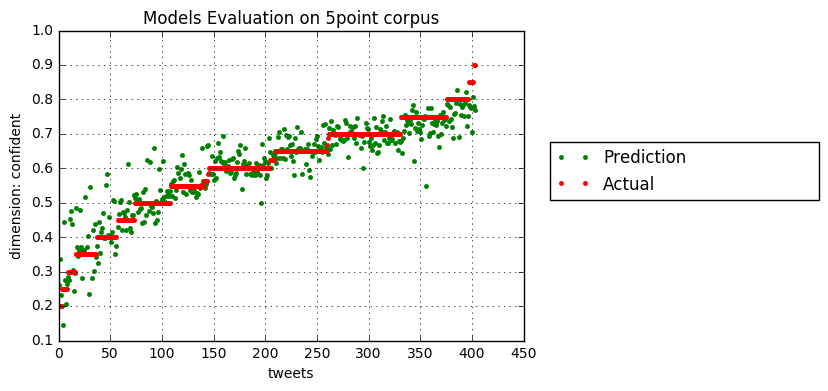

In [349]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import natsort

dimension = 0

s = y_test[:, dimension] #y_annotated[dimension]
order = sorted(range(len(s)), key=lambda k: s[k])

g1 = y_test[:, dimension]
g2 = y_test_predict[:, dimension]   

#--------------          ----SCALING----
line_1, = plt.plot(np.array(g2)[order], 'g.', label='Prediction')
line_0, = plt.plot(np.array(g1)[order], 'r.',  label='Actual')

plt.grid(True)
plt.legend(handles=[line_0, line_1])
plt.legend(bbox_to_anchor=(1.02, .4, .65, .0), loc=3,ncol=1, mode="expand", borderaxespad=1.0)
plt.ylabel('dimension: '+emoNames[dimension])
plt.xlabel('tweets')
plt.title("Models Evaluation on 5point corpus")
plt.show()

### Save Model and Weights

In [351]:
def _save_model_wassa(model, savePath, emo, modelName):
    if emo == None:
        savePath = os.path.join(savePath,modelName)
    else:
        savePath = savePath+"."+emo
        
    model_json = model.to_json()
    with open(savePath + ".json", "w") as json_file:
        json_file.write(model_json)
        print("<%s.json> " % (savePath))
        
    model.save_weights(savePath +".h5", overwrite=True)
    print("<%s.h5> " % (savePath))
    
#     model.save(savePath + "_.h5")
#     print("<"+savePath + "_.h5>")
    
savePath = "/home/vlaand/IpythonNotebooks/senpy-plugins-development/fivePointRegression/classifiers/LSTM/"


_save_model_wassa(model=model, savePath=savePath, emo=None, modelName="fivePointRegression")
_save_model_wassa(model=model, savePath='/home/vlaand/IpythonNotebooks/cf-5point-data/classifiers/LSTM', emo=None, modelName="fivePointRegression")

</home/vlaand/IpythonNotebooks/senpy-plugins-development/fivePointRegression/classifiers/LSTM/fivePointRegression.json> 
</home/vlaand/IpythonNotebooks/senpy-plugins-development/fivePointRegression/classifiers/LSTM/fivePointRegression.h5> 
</home/vlaand/IpythonNotebooks/cf-5point-data/classifiers/LSTM/fivePointRegression.json> 
</home/vlaand/IpythonNotebooks/cf-5point-data/classifiers/LSTM/fivePointRegression.h5> 


#### Load

In [ ]:
with open('model_fivePointRegression.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model_fivePointRegression.h5")
# print("Loaded model from disk")